In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro,levene

The gross margin and gross income columns seems to be a bit misleading so I am going to work without them. This dataset does not have a verified source so it is possible that these columns are not accurate.

In [2]:
fulldata = pd.read_csv('supermarket_sales - Sheet1.csv')
data = fulldata.drop(columns=['gross margin percentage', 'gross income'])
data

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.1


Checking for Missing Values (Kaggle usually does this already)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Invoice ID     1000 non-null   object 
 1   Branch         1000 non-null   object 
 2   City           1000 non-null   object 
 3   Customer type  1000 non-null   object 
 4   Gender         1000 non-null   object 
 5   Product line   1000 non-null   object 
 6   Unit price     1000 non-null   float64
 7   Quantity       1000 non-null   int64  
 8   Tax 5%         1000 non-null   float64
 9   Total          1000 non-null   float64
 10  Date           1000 non-null   object 
 11  Time           1000 non-null   object 
 12  Payment        1000 non-null   object 
 13  cogs           1000 non-null   float64
 14  Rating         1000 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 117.3+ KB


•	Are there any specific dates with significantly higher or lower sales? (Outlier analysis)

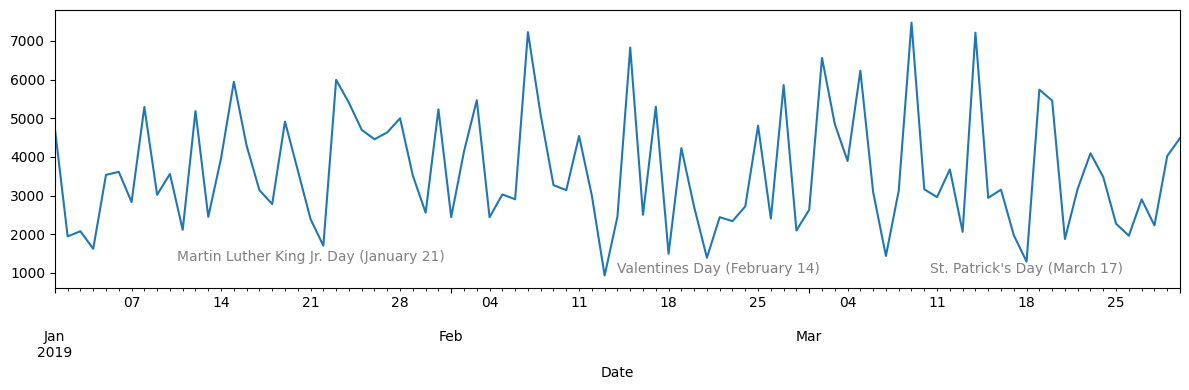

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
daily = data.groupby('Date')['Total'].sum()
daily

fig, ax = plt.subplots(figsize = (12, 4))
daily.plot(ax = ax)

style = dict(size = 10, color = 'gray')
ax.text('2019-1-21', 1300, "Martin Luther King Jr. Day (January 21)", ha = 'center', **style)
ax.text('2019-2-14', 1000, "Valentines Day (February 14)", ha = 'left', **style)
ax.text('2019-3-18', 1000, "St. Patrick's Day (March 17)", ha = 'center', **style)

plt.tight_layout()
# plt.savefig('outlierAnalysis.pdf')

Are there any specific times of day where sales are higher?

C:\Users\johnw\AppData\Local\Temp\ipykernel_27844\1799887171.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_times = data.groupby('Time_Bin')['cogs'].sum()


Text(0.5, 1.0, 'Value of Sales by Time of Day')

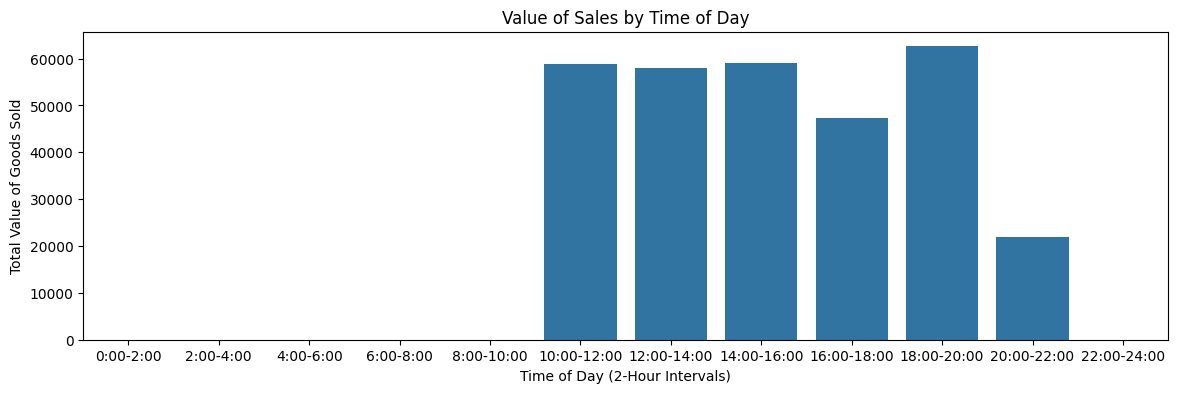

In [5]:
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M')
data['Hour'] = data['Time'].dt.hour
bins = list(range(0,25,2))
labels = [f'{i:20d}:00-{i+2:20d}:00' for i in bins[:-1]]
data['Time_Bin'] = pd.cut( data['Hour'], bins=bins, labels=labels, right=False)

profit_times = data.groupby('Time_Bin')['cogs'].sum()
profit_times = profit_times.reset_index()
profit_times.columns = ['Time_Bins', 'Total_COGS']
profit_times['Time_Bins'] = profit_times['Time_Bins'].astype(str).str.replace(' ','')
data['Time_Bin'] = data['Time_Bin'].astype(str).str.replace(' ','')

fig, ax = plt.subplots(figsize = (14, 4))
p = sns.barplot(x='Time_Bins', y='Total_COGS', data=profit_times)

ax.set_xlabel('Time of Day (2-Hour Intervals)')
ax.set_ylabel('Total Value of Goods Sold')
ax.set_title('Value of Sales by Time of Day')

Major holidays in 2019 from January through March including MLK jr.(Jan. 21), Valentines(Feb. 14), Presidents(Feb. 18), and St. Particks(Mar. 18) all show low Total cost.

•	Are there significant differences in Supermarket branch performance based on daily sales?


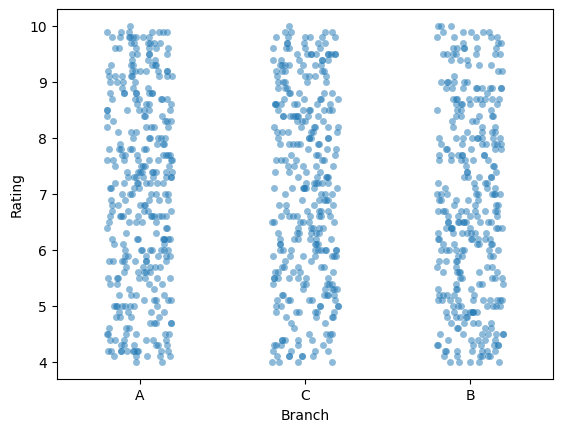

In [6]:
#Visualization
p = sns.stripplot(data, y='Rating', x='Branch', jitter=0.2, alpha=0.5)


Test to see if the three branches sales data comes from the same distribution.

In [7]:
# Format
bran_sales = data.groupby([data['Date'].dt.date, 'Branch'])['cogs'].sum()
bran_salesA = bran_sales[(slice(None),'A')]
bran_salesB = bran_sales[(slice(None),'B')]
bran_salesC = bran_sales[(slice(None),'C')]
bran_sales = bran_sales.reset_index()
data['Branch'] = data['Branch'].astype('category')
#Outliers
bran_salesA

Date
2019-01-01    2258.40
2019-01-02     292.43
2019-01-03     892.77
2019-01-04     460.25
2019-01-05    1928.10
               ...   
2019-03-26    1130.80
2019-03-27    1010.12
2019-03-28    1574.22
2019-03-29     931.06
2019-03-30    1257.73
Name: cogs, Length: 89, dtype: float64

Text(0.5, 1.0, 'Distribution of Sales by Branch')

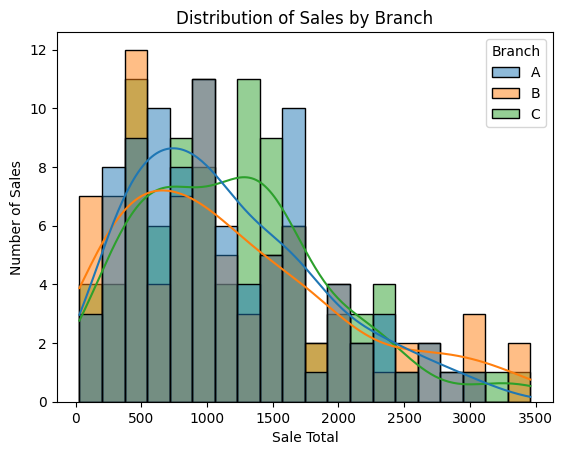

In [8]:
sns.histplot(data=bran_sales, x='cogs', hue='Branch', bins=20, kde=True)

plt.xlabel('Sale Total')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales by Branch')

Test to see if these samples come from the same distribution

In [9]:
import scipy.stats as stats

# Assume data1, data2, and data3 are your three samples (arrays, lists, etc.)
result = stats.anderson_ksamp([bran_salesA, bran_salesB, bran_salesC])

print("Test Statistic:", result.statistic)
print("Significance Level (p-value):", result.significance_level)

# p_val > 0.25 and has been capped, this is significant evidence that I 
#cannot reject the null that these samples come from the same distribution

Test Statistic: -0.5068156496838838
Significance Level (p-value): 0.25


C:\Users\johnw\AppData\Local\Temp\ipykernel_27844\4214957912.py:4: UserWarning: p-value capped: true value larger than 0.25
  result = stats.anderson_ksamp([bran_salesA, bran_salesB, bran_salesC])


In [10]:
#Check normality
stat_A, p_A = shapiro(bran_salesA)
stat_B, p_B = shapiro(bran_salesB)
stat_C, p_C = shapiro(bran_salesC)

print(f"Shapiro-Wilk Test p-values: A = {p_A}, B = {p_B}, C = {p_C}")

#Check homogeneity of variance
stat_levene, p_levene = levene(bran_salesA, bran_salesB, bran_salesC)
print(f"Levene's Test p-value: {p_levene}")

#Distributions are not normal enough for ANOVA test of equal means, kruskal is non parametric version
h_stat, p_value = stats.kruskal(bran_salesA, bran_salesB, bran_salesC)
print("Kruskal-Wallis H-statistic:", h_stat)
print("p-value:", p_value)


Shapiro-Wilk Test p-values: A = 0.0003945055650547147, B = 4.999710654374212e-05, C = 0.0018746377900242805
Levene's Test p-value: 0.29347685169089643
Kruskal-Wallis H-statistic: 0.5158112462123654
p-value: 0.7726681506859727


Distributions do not have equal variance and are not normally distributed so I used a kruskal_wallis test for central tendency. Branches do not have a significantly different mean.

•	Does a product line need more stock based on purchase quantities? (Predict necessary supply)

Axes(0.125,0.11;0.775x0.77)


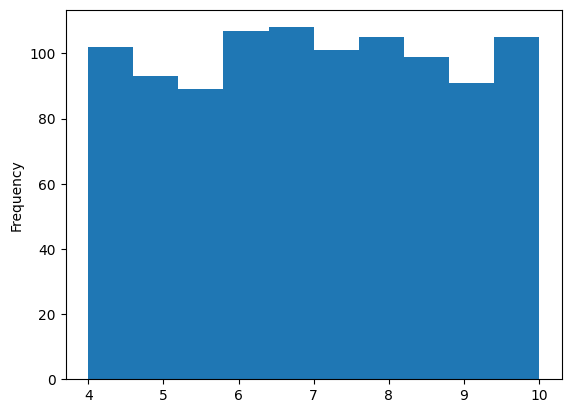

In [11]:
print(data['Rating'].plot(kind='hist')) #Rating follows a uniform distribution

Performing DT

In [12]:
#Check Data Types:  Make sure categorical variables are indeed treated as categories.
# In Pandas, need to make sure that the type of your column is category.

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
#There are many metrics for DT that I might want to look into



X = data[['Product line', 'Time_Bin', 'Gender', 'Branch', 'Unit price']]
y = data['Rating'].round(0).astype('int')

X.dtypes


Product line      object
Time_Bin          object
Gender            object
Branch          category
Unit price       float64
dtype: object

•	Can we predict customer ratings based on factors product line, time of purchase, gender, branch, unit price?(Potentially compare techniques such as logistic regression vs decision trees)

Most likely decision trees will make more sense because there are no linear correlations.

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(X[['Product line','Time_Bin','Gender','Branch']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Product line','Time_Bin','Gender','Branch'])) # Create new dataframe with encoded data
X_encoded = pd.concat([X.drop(['Product line','Time_Bin','Gender','Branch'], axis=1), encoded_df], axis=1) # Drop the old columns and add encoded ones

X_encoded.dtypes

Unit price                             float64
Product line_Electronic accessories    float64
Product line_Fashion accessories       float64
Product line_Food and beverages        float64
Product line_Health and beauty         float64
Product line_Home and lifestyle        float64
Product line_Sports and travel         float64
Time_Bin_10:00-12:00                   float64
Time_Bin_12:00-14:00                   float64
Time_Bin_14:00-16:00                   float64
Time_Bin_16:00-18:00                   float64
Time_Bin_18:00-20:00                   float64
Time_Bin_20:00-22:00                   float64
Gender_Female                          float64
Gender_Male                            float64
Branch_A                               float64
Branch_B                               float64
Branch_C                               float64
dtype: object

In [14]:
###IT IS LIKELY THAT MY MODEL IS NOT ABLE TO CREATE PURE LEAF NODES
### AS A RESULT THE GROUPS AFTER DT HAVE A LARGE RANGE OF VALUES AND THE MEAN VALUE IS PREDICTED
# Compute correlation between categorical features and target
corr_matrix = X_encoded.apply(lambda col: col.astype('category').cat.codes).corrwith(pd.Series(y))

print(corr_matrix.sort_values(ascending=False))  # Sort by highest correlation


Time_Bin_12:00-14:00                   0.057705
Branch_C                               0.034648
Product line_Food and beverages        0.029903
Branch_A                               0.025284
Product line_Fashion accessories       0.021044
Product line_Health and beauty         0.012103
Gender_Male                            0.006100
Time_Bin_10:00-12:00                   0.001098
Product line_Electronic accessories   -0.004078
Gender_Female                         -0.006100
Time_Bin_20:00-22:00                  -0.008724
Unit price                            -0.011828
Time_Bin_16:00-18:00                  -0.015909
Time_Bin_18:00-20:00                  -0.017700
Time_Bin_14:00-16:00                  -0.020623
Product line_Sports and travel        -0.020736
Product line_Home and lifestyle       -0.039508
Branch_B                              -0.059974
dtype: float64


In [15]:
#DT
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=3, test_size=.1)

Regressor = DecisionTreeRegressor(random_state=5, max_depth=3)

# NEED to prune this decision tree(set up a recursion to pick the best hyperparameters based on MSE)

Regressor.fit(X_train, y_train)
y_predicted = Regressor.predict(X_test)
y_predictedRounded = y_predicted.round(0)
print(y_predicted)

print(np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted)))

accuracy = pd.DataFrame(y_predicted, y_test)
accuracy

# X_encoded.columns


[7.05025126 7.01033058 6.5        7.01033058 7.01033058 7.01033058
 7.01033058 7.31531532 7.31531532 4.6        7.01033058 7.05025126
 6.66666667 7.01033058 7.01033058 6.48       7.31531532 7.01033058
 7.01033058 7.01033058 7.05025126 7.01033058 7.31531532 7.31531532
 7.05025126 7.01033058 7.01033058 7.01033058 7.01033058 7.31531532
 7.01033058 7.01033058 7.31531532 7.01033058 7.31531532 7.05025126
 7.01033058 7.31531532 7.01033058 7.31531532 7.05025126 7.01033058
 7.01033058 7.05025126 7.01033058 7.01033058 7.05025126 7.01033058
 7.01033058 7.01033058 6.48       7.01033058 7.05025126 7.01033058
 7.01033058 7.01033058 7.01033058 7.01033058 7.05025126 6.48
 7.05025126 6.5        7.31531532 7.05025126 7.05025126 6.5
 7.01033058 7.01033058 7.01033058 7.01033058 7.01033058 7.01033058
 7.31531532 6.48       7.05025126 7.01033058 7.01033058 7.01033058
 7.01033058 7.01033058 7.31531532 7.05025126 6.5        7.01033058
 7.05025126 6.48       7.05025126 7.05025126 7.01033058 7.31531532
 7.01033

,0
Rating,
6,7.050251
10,7.010331
4,6.500000
6,7.010331
9,7.010331
...,...
6,7.315315
6,6.480000
4,7.050251


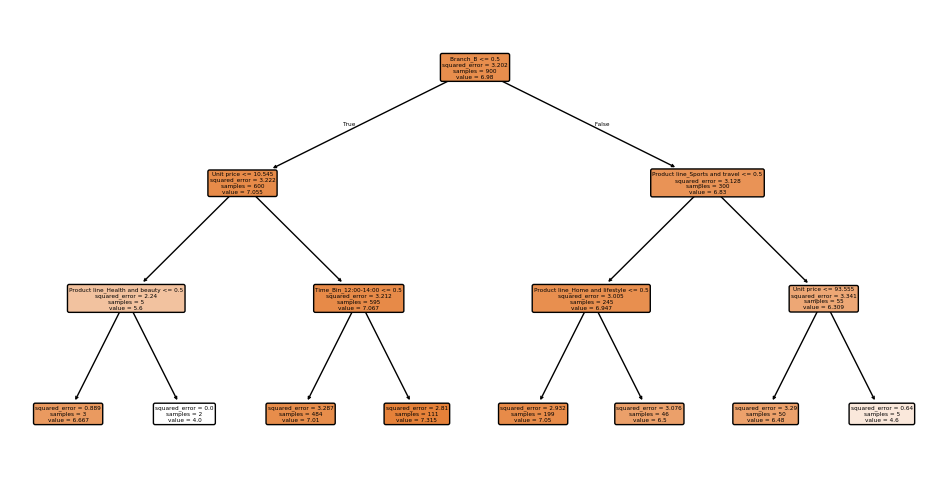

In [16]:
plt.figure(figsize=(12, 6))
plot_tree(Regressor, feature_names=['Unit price', 'Product line_Electronic accessories',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel', 'Time_Bin_10:00-12:00',
       'Time_Bin_12:00-14:00', 'Time_Bin_14:00-16:00', 'Time_Bin_16:00-18:00',
       'Time_Bin_18:00-20:00', 'Time_Bin_20:00-22:00', 'Gender_Female',
       'Gender_Male', 'Branch_A', 'Branch_B', 'Branch_C'], filled=True, rounded=True)
plt.show()

In [17]:
DTRegressor = RandomForestRegressor(random_state=5)


# Define hyperparameter grid
param_grid = {
    "n_estimators": [20, 50, 100],
    "max_depth": [3, 5, 10, None],  # None means no depth limit
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DTRegressor,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # MSE (negative because higher is worse)
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores for speed
)

grid_search.fit(X=X_encoded, y=y)

# Get best parameters and lowest MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_  # Convert back to positive MSE

print(f"Best Hyperparameters: {best_params}")
print(f"Lowest MSE from CV: {best_mse:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_true=y_test, y_pred=Y_pred)

print(f"Test Set MSE: {test_mse:.4f}")


#In both the basic decision tree and the random forest, predictions are being pulled twards the mean. 
# This is likely an issue with how random forests aggregate average parameters. First I will check other assumptions.

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Lowest MSE from CV: 3.2786
Test Set MSE: 3.2680


#Check importance of different parameters to check for dominance

#possibly just better to not use random forests in this example

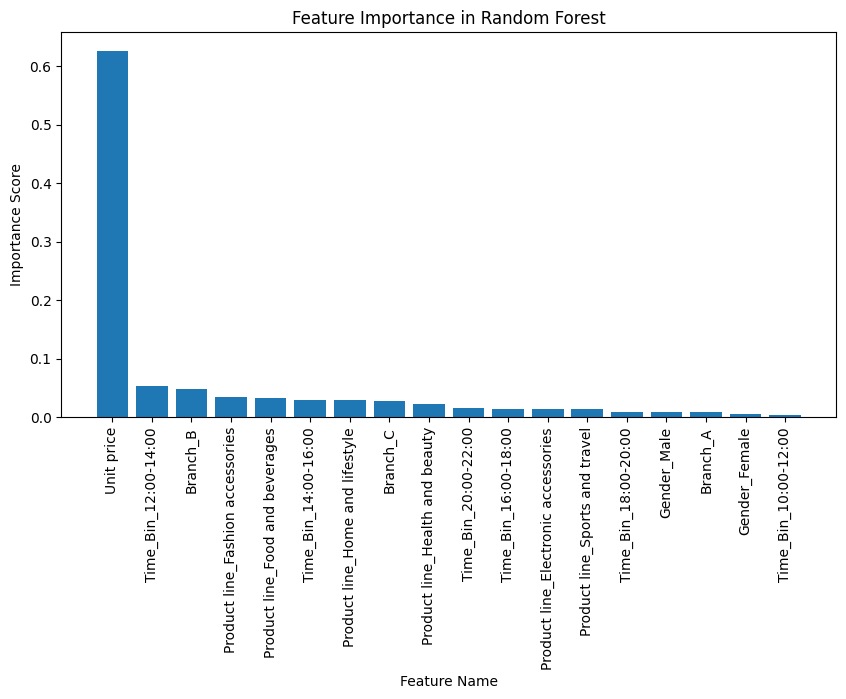

In [18]:

import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feature_names = X_encoded.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Random Forest")
plt.show()

As the only continuous variable unit price might have a lot more variance per observation making it dominant in the model. Unit price is not a meaningfull variable in this sense anyway as it is not capturing any meaninful information about reviews.

#Remove unit price and reperform random forest

In [19]:
from sklearn.preprocessing import StandardScaler

X_encoded2 = X_encoded.copy()
scaler = StandardScaler()
X_encoded2 = X_encoded2.drop(columns='Unit price')
X_encoded2.columns

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded2, y, random_state=3, test_size=.1)

#Refit
DTRegressor2 = RandomForestRegressor(random_state=5)

# Define hyperparameter grid
param_grid2 = {
    "n_estimators": [20, 50, 100],
    "max_depth": [3, 5, 10, None],  # None means no depth limit
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search2 = GridSearchCV(
    estimator=DTRegressor2,
    param_grid=param_grid2,
    scoring="neg_mean_squared_error",  # MSE (negative because higher is worse)
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores for speed
)

grid_search2.fit(X=X_encoded2, y=y)

# Get best parameters and lowest MSE
best_params2 = grid_search2.best_params_
best_mse2 = -grid_search2.best_score_  # Convert back to positive MSE

print(f"Best Hyperparameters: {best_params2}")
print(f"Lowest MSE from CV: {best_mse2:.4f}")

# Evaluate on test set
best_model2 = grid_search2.best_estimator_
Y_pred2 = best_model2.predict(X_test2)

test_mse2 = mean_squared_error(y_true=y_test2, y_pred=Y_pred2)

print(f"Test Set MSE: {test_mse2:.4f}")
print(Y_pred2)

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}
Lowest MSE from CV: 3.2657
Test Set MSE: 3.3765
[6.88001129 6.95436275 6.64208232 7.04440283 7.03223904 7.01936742
 6.90033703 7.19503251 7.14899799 6.62082626 7.11184525 6.90732723
 7.40037833 7.01428771 7.22364241 6.7119288  7.18971925 7.28111367
 6.9508186  6.86817149 6.89614672 6.95478339 7.04008608 7.19503251
 6.87843062 6.90033703 7.11062948 7.06053142 7.00338537 7.03288488
 7.08556631 6.84527725 7.19503251 7.01936742 7.36285656 6.87730166
 6.95920913 7.12793639 6.88039855 7.22946206 6.9882773  6.92909203
 7.06361686 6.76121009 7.13594498 6.95310331 6.92344653 7.04775375
 6.97635195 6.84527725 6.74021569 7.03820149 6.88001129 6.87450061
 6.91358646 6.94035501 7.28111367 7.04440283 6.76121009 6.790583
 6.84640379 6.78914323 7.19503251 7.02478945 6.89614672 6.60221415
 7.08229291 7.08133381 7.28111367 7.077654   7.01231653 6.97938621
 7.36382906 6.74021569 6.80304822 6.9908022

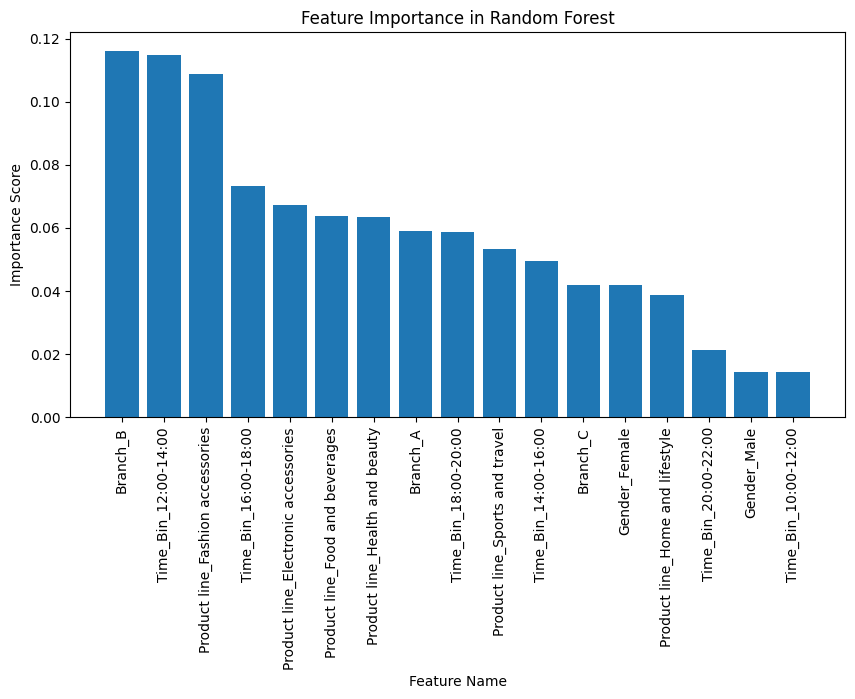

In [20]:
#Dropped unit price 
importances2 = best_model2.feature_importances_
feature_names2 = X_encoded2.columns
sorted_idx2 = np.argsort(importances2)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances2)), importances2[sorted_idx2], align="center")
plt.xticks(range(len(importances2)), feature_names2[sorted_idx2], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Random Forest")
plt.show()

After removing the variable dominating the model we still have a tendency twards the median value, which is common with random forests. 
I will try try to fit a basic decision tree without unit price or random forests.

In [21]:
DT3 = DecisionTreeRegressor(random_state=6)

# Define hyperparameter grid
param_grid_3 = {
    "max_depth": [3, 5, 10, 20, 30, None],  # None means no depth limit
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["squared_error", "friedman_mse"]
}

grid_search3 = GridSearchCV(
    estimator=DT3,
    param_grid=param_grid_3,
    scoring="neg_mean_squared_error",  # MSE (negative because higher is worse)
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores for speed
)

grid_search3.fit(X=X_encoded2, y=y)

# Get best parameters and lowest MSE
best_params3 = grid_search3.best_params_
best_mse3 = -grid_search3.best_score_  # Convert back to positive MSE

print(f"Best Hyperparameters: {best_params3}")
print(f"Lowest MSE from CV: {best_mse3:.4f}")

# Evaluate on test set
best_model3 = grid_search3.best_estimator_
Y_pred3 = best_model3.predict(X_test2)

test_mse3 = mean_squared_error(y_true=y_test, y_pred=Y_pred3)

print(f"Test Set MSE: {test_mse3:.4f}")
print(Y_pred3)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Lowest MSE from CV: 3.3345
Test Set MSE: 3.4929
[6.99545455 7.04269663 6.52       7.04269663 7.04269663 7.04269663
 7.04269663 7.39252336 7.39252336 6.47540984 7.04269663 6.99545455
 7.39252336 7.04269663 7.04269663 6.47540984 7.39252336 7.04269663
 7.04269663 7.04269663 6.99545455 7.04269663 6.72727273 7.39252336
 6.99545455 7.04269663 7.04269663 7.04269663 6.77659574 6.72727273
 7.04269663 6.77659574 7.39252336 7.04269663 7.39252336 6.99545455
 7.04269663 7.39252336 6.77659574 7.39252336 6.99545455 7.04269663
 7.04269663 6.99545455 7.04269663 7.04269663 6.99545455 7.04269663
 7.04269663 6.77659574 6.47540984 7.04269663 6.99545455 7.04269663
 7.04269663 7.04269663 7.04269663 7.04269663 6.99545455 6.47540984
 6.99545455 6.52       7.39252336 6.99545455 6.99545455 6.52
 7.04269663 7.04269663 7.04269663 7.04269663 7.04269663 7.04269663
 7.39252336 6.47540984 6.99545455 6.77

###IT IS LIKELY THAT MY MODEL IS NOT ABLE TO CREATE PURE LEAF NODES, AS A RESULT THE GROUPS AFTER DT HAVE A LARGE RANGE OF VALUES AND THE MEAN VALUE OF THE DATASE KEEPS GETTING PREDICTED

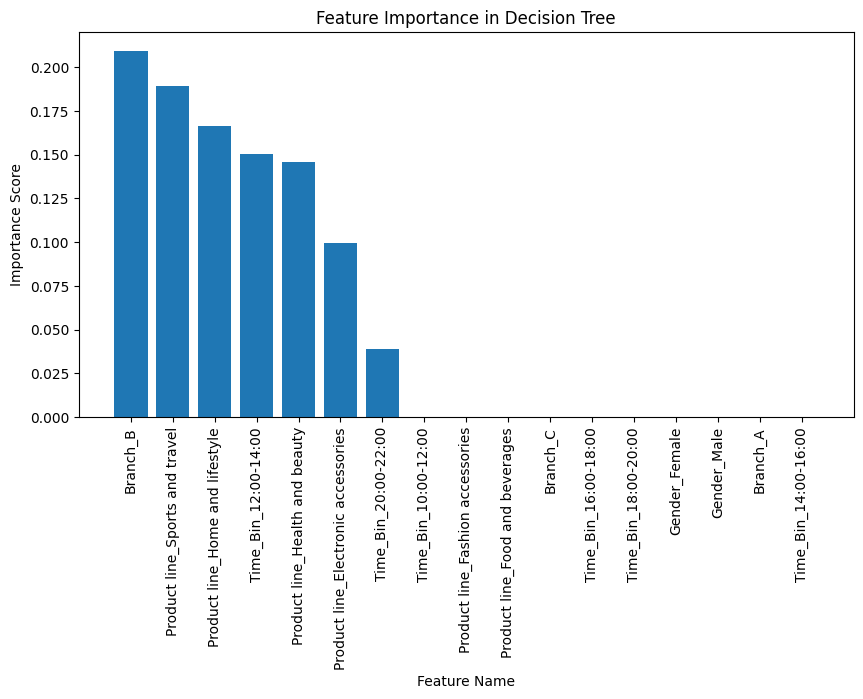

In [22]:
#Standard decision tree (no random forest)
importances3 = best_model3.feature_importances_
feature_names = X_encoded2.columns
sorted_idx3 = np.argsort(importances3)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances3)), importances3[sorted_idx3], align="center")
plt.xticks(range(len(importances3)), feature_names[sorted_idx3], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Decision Tree")
plt.show()



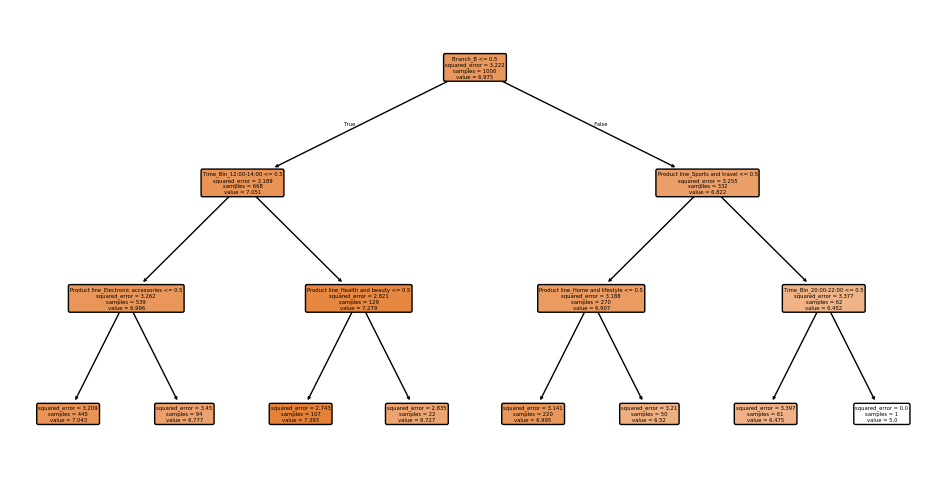

In [23]:
plt.figure(figsize=(12, 6))
plot_tree(best_model3, feature_names=['Product line_Electronic accessories',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel', 'Time_Bin_10:00-12:00',
       'Time_Bin_12:00-14:00', 'Time_Bin_14:00-16:00', 'Time_Bin_16:00-18:00',
       'Time_Bin_18:00-20:00', 'Time_Bin_20:00-22:00', 'Gender_Female',
       'Gender_Male', 'Branch_A', 'Branch_B', 'Branch_C'], filled=True, rounded=True)

# Save to a high-quality image file (PNG format)
plt.savefig('decision_tree_high_res.png', dpi=300, bbox_inches='tight')


plt.show()

Practice developing a stochastic model weekly product consumption in order to guarantee appropriate stock for branch C. 

In [24]:
branchC_entries = data[data['Branch'] == 'C']
# branchC_entries
branchC_entries['Date'].sort_values()

#It is probably best to project this by product line and aggregate per day

523   2019-01-01
496   2019-01-01
484   2019-01-01
839   2019-01-01
300   2019-01-02
         ...    
988   2019-03-29
963   2019-03-30
643   2019-03-30
881   2019-03-30
646   2019-03-30
Name: Date, Length: 328, dtype: datetime64[ns]

In [25]:
Product_sales = branchC_entries.groupby(['Date', 'Product line'])['Quantity'].sum()
# Product_sales

#fill in missing dates with zero

Electronics = Product_sales[(slice(None),'Electronic accessories')]
Electronics = pd.DataFrame(Electronics)

Electronics.columns = ['Sales']
Electronics

,Sales
Date,
2019-01-01,2
2019-01-04,9
2019-01-09,7
2019-01-10,5
2019-01-13,10
2019-01-14,16
2019-01-15,10
2019-01-19,4
2019-01-23,4


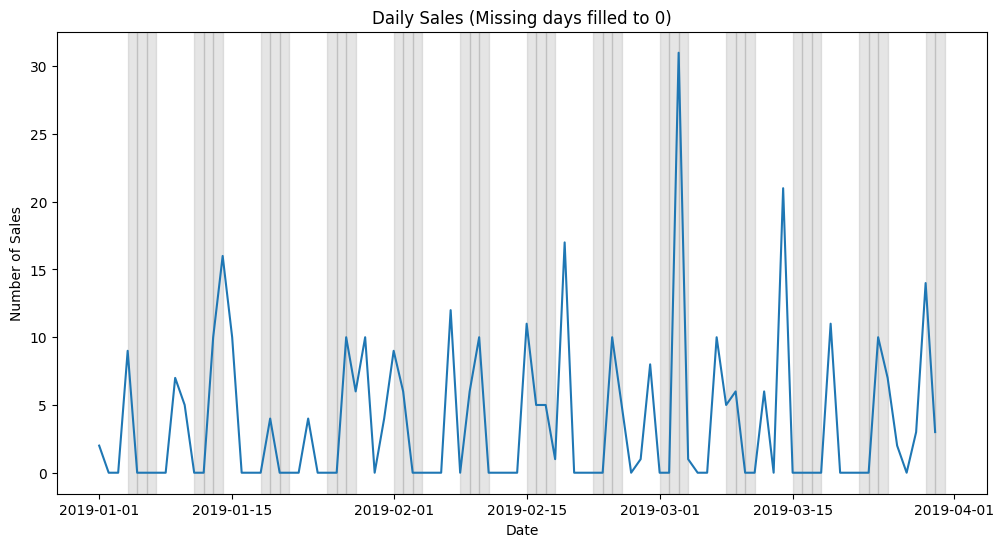

In [26]:
Electronics_daily = Electronics.resample('D').sum().fillna(0)

# Identify weekends (Friday, Saturday and Sunday)
weekends = Electronics_daily.index[Electronics_daily.index.weekday >= 4]

# Plot the resampled daily data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Electronics_daily.index, Electronics_daily['Sales'], label='Daily Sales')

# Highlight weekends with grey shading
for day in weekends:
    ax.axvspan(day, day + pd.Timedelta(days=1), color='gray', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Sales')
ax.set_title('Daily Sales (Missing days filled to 0)')
plt.show()

Vertical dashed lines for weekends. Surprisingly no visible sales patterns around the weekends.

In [27]:
# Perform the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(Electronics_daily, autolag='AIC')  # 'AIC' automatically selects the number of lags

# Unpack the results
adf_statistic = result[0]
p_value = result[1]
used_lags = result[2]
n_obs = result[3]
critical_values = result[4]
icbest = result[5]

# Print the results
print("ADF Statistic: {:.4f}".format(adf_statistic))
print("p-value: {:.4f}".format(p_value))
print("Number of lags used: {}".format(used_lags))
print("Number of observations: {}".format(n_obs))
print("Critical Values:")
for key, value in critical_values.items():
    print("\t{}: {:.4f}".format(key, value))
print("IC Best (AIC value): {:.4f}".format(icbest))

ADF Statistic: -7.2597
p-value: 0.0000
Number of lags used: 2
Number of observations: 86
Critical Values:
	1%: -3.5088
	5%: -2.8958
	10%: -2.5850
IC Best (AIC value): 485.9118


This data is about perfectly stationary without any seasonality ajustments. It is unusual for this to appear naturally but may be due to the constatnt demand or possibly just because my time frame is so short.

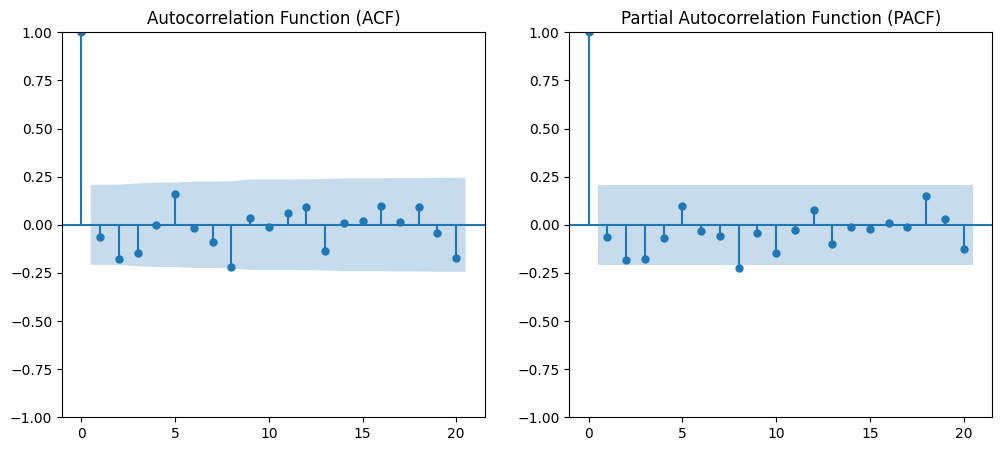

In [28]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your stationary sales data
# Ensure it's a pandas Series with DateTime index
sales_data = Electronics_daily

# Plot ACF and PACF
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(sales_data, lags=20, ax=plt.gca())  # ACF plot
plt.title("Autocorrelation Function (ACF)")

plt.subplot(122)
plot_pacf(sales_data, lags=20, ax=plt.gca())  # PACF plot
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()


ACF and PACF plots both exibit hard drop off after the zero term suggesting that my data is neither AR or MA. This combined with the high stationarity of the data suggests that my data is perfectly deterministic or white noise. Either way the output suggests that the best parameters for ARIMA would be (1, 0, 1)

However it is assumed from the buisness sense that sales would not be dependent on past days sales (Autoregressive) and would instead follow random fluctuations based on previous error terms (Moving Average). Additionally since my data appears to be perfectly stationary there is no need for Integration.

c:\Users\johnw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\johnw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   89
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -276.371
Date:                Sun, 16 Mar 2025   AIC                            560.741
Time:                        13:52:02   BIC                            570.696
Sample:                    01-01-2019   HQIC                           564.754
                         - 03-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7870      0.320     11.847      0.000       3.161       4.414
ar.L1          0.6894      0.186      3.711      0.000       0.325       1.053
ma.L1         -0.8939      0.100     -8.982      0.0

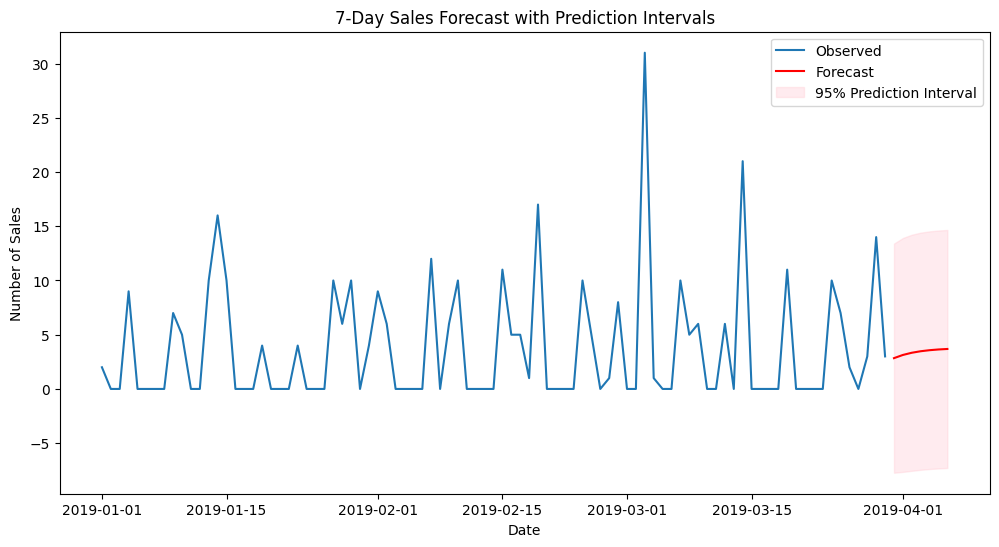

In [29]:
# Fit an ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Note: Here we use ARIMA(1,0,1) as an example. You may want to determine the best order via ACF/PACF analysis or auto_arima.
model = ARIMA(Electronics_daily['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next 7 days with prediction intervals (95% confidence)
forecast_result = model_fit.get_forecast(steps=7)
forecast_df = forecast_result.summary_frame(alpha=0.05)
print("\nForecast with Prediction Intervals:")
print(forecast_df)

# Create a date range for the forecasted days
forecast_index = pd.date_range(start=Electronics_daily.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

# Plot the forecast and prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(Electronics_daily.index, Electronics_daily['Sales'], label='Observed')
plt.plot(forecast_index, forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3, label='95% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('7-Day Sales Forecast with Prediction Intervals')
plt.legend()
plt.show()

The confidence interval for the forecast is going negative which doesnt make sense in this case, however it doesnt have much significance. For the comapny's uses the upper limit of the confidence interval is much more imporatnt. You can interpret the upper and lower limits as the number of sales having a 95% chance to be withing this interval.

Potential alternative SARIMAX model for seasonality if it is decided that I should model my data under the assumption that there are differences in sales on weekends.

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                   89
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -281.546
Date:                           Sun, 16 Mar 2025   AIC                            573.092
Time:                                   13:52:03   BIC                            585.536
Sample:                               01-01-2019   HQIC                           578.108
                                    - 03-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.108      9.242      0.000       0.788       1.211
ma.L1         -0.9956      0.599     -1.663

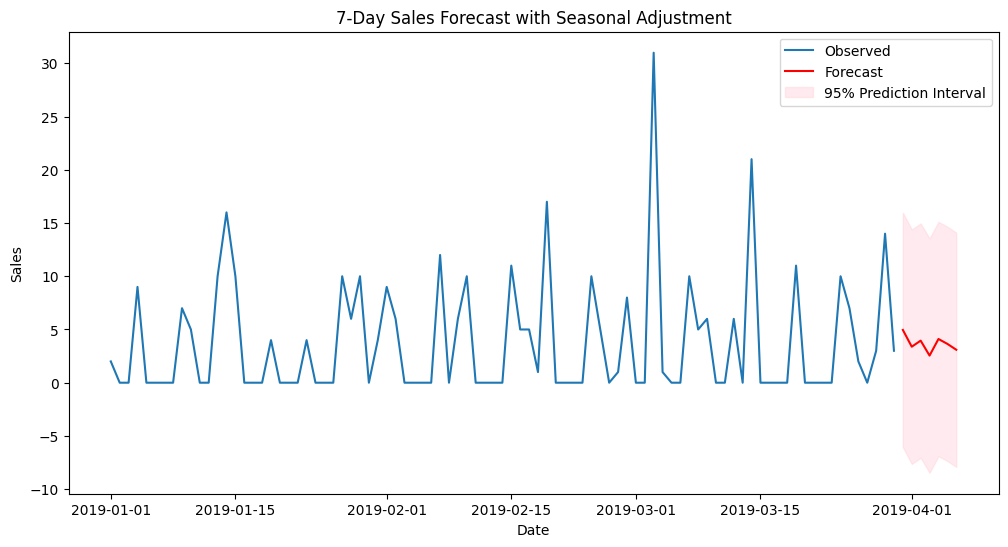

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a seasonal ARIMA model (SARIMA) with weekly seasonality.
# Here, seasonal_order=(1, 0, 1, 7) means:
#   - Seasonal period of 7 (for a week)
model = SARIMAX(Electronics_daily['Sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next 7 days with 95% prediction intervals.
forecast_result = model_fit.get_forecast(steps=7)
forecast_df = forecast_result.summary_frame(alpha=0.05)
print("\nForecast with Prediction Intervals:")
print(forecast_df)

# Create a date range for the forecasted days
forecast_index = pd.date_range(start=Electronics_daily.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

# Plot the forecast and prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(Electronics_daily.index, Electronics_daily['Sales'], label='Observed')
plt.plot(forecast_index, forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3, label='95% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('7-Day Sales Forecast with Seasonal Adjustment')
plt.legend()
plt.show()

Both seasonal coefficients—ar.S.L7 (0.9989, p ≈ 0.114) and ma.S.L7 (-0.9895, p ≈ 0.749)—are not statistically significant. Their large standard errors and wide confidence intervals indicate that the seasonal effects may not be reliably estimated, suggesting the seasonal component might be over-parameterized or not needed.